## Загрузка данных

In [1]:
# !pip install transformers

Загрузим данные, которые мы будем использовать для обучения


In [2]:
import pandas as pd

df = pd.read_csv("new.csv", index_col=0)
df['Reviews'] = df['Reviews'].astype(str)
df = df.drop('PreprocessedText', axis=1)
df = df.reset_index(drop=True)
df.head()

,Reviews,Практика,Теория,Преподаватель,Технологии,Актуальность
0,"Понравилась структурvveа курса, заострение вни...",0,0,0,1,1
1,Неплохой курс для начала изучения С/C++. Лекто...,0,1,1,1,0
2,"клевый курс, освежил знания",0,1,0,0,0
3,Очень позитивный и веселый преподаватель! инте...,0,0,1,0,0
4,"Впечатления сугубо положительные, пожалуй курс...",1,0,0,0,0


In [3]:
df.shape

(2380, 6)

Посмотрим на распределение классов в выборке

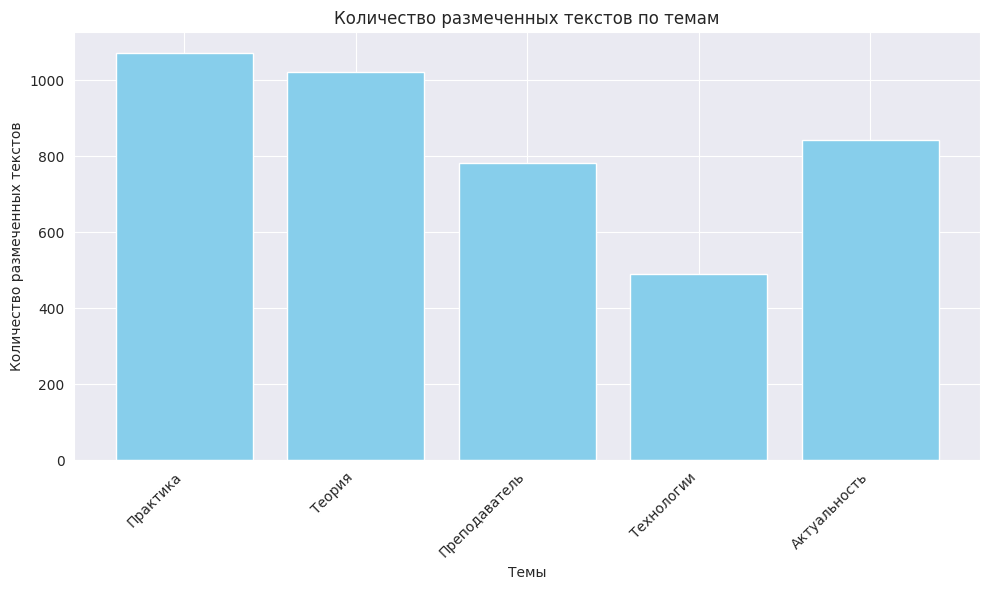

In [4]:
import matplotlib.pyplot as plt

topic_keywords = list(df.columns[1:])

# Создание списков для тем и их количества
counts = [len(df[df[t] == 1]) for t in topic_keywords]

# Визуализация

plt.figure(figsize=(10, 6))
plt.bar(topic_keywords, counts, color='skyblue')
plt.xlabel('Темы')
plt.ylabel('Количество размеченных текстов')
plt.title('Количество размеченных текстов по темам')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Предобработка данных

При работе с моделью BERT предобработка в традиционном смысле (удаление стоп-слов, знаков препинания) не требуется.

Нужна предобработка другого рода:
* добавление спецтокенов для разделения предложений [SEP] и классификации [CLS]
* приведение всех предложений к одинаковой длине (паддинг)
* создание маски внимания (attention mask) — списка  из 0 и 1, где 0 соответствует вспомогательным токенам (padding), а 1 — настоящим.

Нам не нужно самим добавлять спецсимволы и составлять словарь соответствия токенов и индексов. Это сделает токенизатор, соотвествующий выбранной модели. Сегодня мы будем использовать модель 'bert-base-cased'.

In [5]:
PRE_TRAINED_MODEL_NAME = 'DeepPavlov/rubert-base-cased'

In [6]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, clean_up_tokenization_spaces=True)

Вспомним, как работает модель токенизации для BERT.

- Токенизируйте текст `sample_txt` и переведите токены `tokens` в индексы `token_ids`.

In [7]:
sample_txt = df.loc[0, 'Reviews']
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'Предложение: {sample_txt}')
print(f'Токены: {tokens}')
print(f'Индексы токенов: {token_ids}')

Предложение: Понравилась структурvveа курса, заострение внимания на деталях, которые скорее всего пригодятся в будущем Блок про ООП показался сумбурным и путанным, с не самыми лучшими примерами
Токены: ['Пон', '##рави', '##лась', 'структур', '##v', '##ve', '##а', 'курса', ',', 'заостр', '##ение', 'внимания', 'на', 'деталях', ',', 'которые', 'скорее', 'всего', 'пригод', '##ятся', 'в', 'будущем', 'Блок', 'про', 'ООП', 'показался', 'сум', '##бурн', '##ым', 'и', 'путан', '##ным', ',', 'с', 'не', 'самыми', 'лучшими', 'примерами']
Индексы токенов: [21161, 107130, 7527, 16904, 275, 11124, 626, 20332, 128, 39307, 2011, 20462, 1469, 59858, 128, 4427, 17254, 6675, 29281, 7173, 845, 19319, 34641, 2061, 61646, 94384, 8039, 52218, 2800, 851, 53707, 2010, 128, 869, 1699, 29257, 43172, 77472]


### Специальные токены

Токенизатор уже содержит индексы для спецсимволов:
- [SEP] — метка конца предложения
- [CLS] — токен для классификации предложения
- [PAD] — токен для выравнивания длин последовательностей

In [8]:
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)

[SEP] 102
[CLS] 101
[PAD] 0


Вся предобработка может быть сделана с помощью метода `encode_plus`. Он возвращает словарь с ключами `input_ids` и `attention_mask`.

In [9]:
# encoding = tokenizer.encode_plus(
# 	sample_txt,  # преобразуемый текст
# 	max_length=256,  # максимальная длина
# 	add_special_tokens=True,  # добавить спецтокены [CLS] и [SEP]
# 	return_token_type_ids=False,  # вернуть номер предложения
# 	padding='max_length',  # паддинг по установленной максимальной длине
# 	return_attention_mask=True,  # создать маску для механизма внимания
# 	return_tensors='pt',  # вернуть тензор PyTorch
# 	truncation=True  # обрезать предложения длинее max_length
# )
# encoding

### Унификация длины предложений

Проанализируем, какая длина отзывов встречается в данных чаще. Отберем отзывы длины менее 512 токенов, поскольку это максимальная длина последовательности для модели BERT.

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


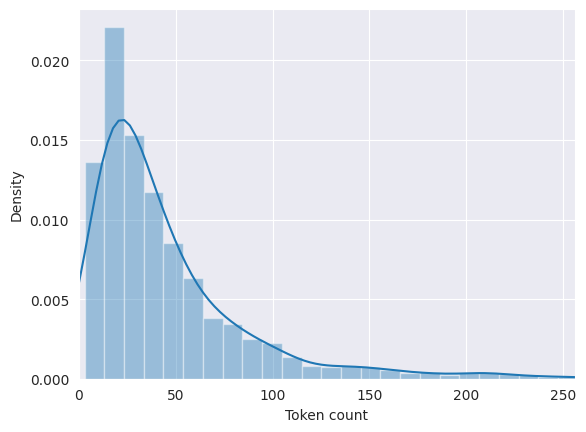

In [10]:
token_lens = []
for txt in df['Reviews'].tolist():
	tokens = tokenizer.encode(txt, max_length=512)
	token_lens.append(len(tokens))

import warnings

warnings.filterwarnings('ignore')

import seaborn as sns

sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

Установим максимальную длину последовательности равной 250.

In [11]:
MAX_LEN = 250


### Создание датасета

Теперь создадим датасет PyTorch, который понадобится для обучения и тестирования модели.
- В методе `__init__` задаем тексты отзывов (`self.reviews`), метки классов (`self.targets`), токенизатор (`self.tokenizer`) и максимальную длину последовательности (`self.max_len`).
- В методе `__len__` определяем размер датасета.
- В методе `__getitem__` сопоставляем тексты отзывов и метки классов по индексу (`item`). Метод возвращает словарь: текст отзыва, индексы токенов, маску внимания, метку класса.

- Добавьте предобработку отзыва `review`: преобразуйте его в словарь `encoding` с помощью метода `encode_plus`, добавьте спецтокены, установите максимальную длину для паддинга, не возвращайте номер предложения, задайте паддинг по максимальной установленной длине, создайте маску для механизма внимания, установите формат списка индексов как тензор pytorch, установите усечение для предложений больше максимальной длины.

In [12]:
from torch.utils.data import Dataset


class GPReviewDataset(Dataset):

	def __init__(self, reviews, targets, tokenizer, max_len):
		self.reviews = reviews
		self.targets = targets
		self.tokenizer = tokenizer
		self.max_len = max_len

	def __len__(self):
		return len(self.reviews)

	def __getitem__(self, item):
		review = str(self.reviews[item])
		target = self.targets[item]

		encoding = self.tokenizer.encode_plus(
			review,  # преобразуемый текст
			max_length=MAX_LEN,  # максимальная длина
			add_special_tokens=True,  # добавить спецтокены [CLS] и [SEP]
			return_token_type_ids=False,  # вернуть номер предложения
			padding='max_length',  # паддинг по установленной максимальной длине
			return_attention_mask=True,  # создать маску для механизма внимания
			return_tensors='pt',  # вернуть тензор PyTorch
			truncation=True  # обрезать предложения длинее max_length
		)
		return {
			'review_text': review,
			'input_ids': encoding['input_ids'].flatten(),
			'attention_mask': encoding['attention_mask'].flatten(),
			'targets': torch.tensor(target, dtype=torch.long)
		}

Разделим данные на обучающую, валидационную и тестовую выборки. 90% всех данных отберем для обучения, оставшиеся 10% поделим пополам для валидации и тестирования.

In [13]:
import torch
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(f'Размеры датасетов:')
print(f'Обучающая выборка: {df_train.shape}')
print(f'Валидационная выборка: {df_val.shape}')
print(f'Тестовая выборка: {df_test.shape}')

Размеры датасетов:
Обучающая выборка: (2142, 6)
Валидационная выборка: (119, 6)
Тестовая выборка: (119, 6)


Определяем устройство для выполнения вычислений (CPU или GPU)

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Создадим итераторы по данным:
- `train_data_loader` — данные для дообучения модели;
- `val_data_loader` — данные для валидации модели при обучении;
- `test_data_loader` — данные для тестирования модели.

In [15]:
from torch.utils.data import DataLoader


def create_data_loader(df, tokenizer, max_len, batch_size):
	ds = GPReviewDataset(
		reviews=df['Reviews'].to_numpy(),
		targets=df[['Практика', 'Теория', 'Преподаватель', 'Технологии', 'Актуальность']].to_numpy(),
		# укажите, какие целевые переменные хотите использовать
		tokenizer=tokenizer,
		max_len=max_len
	)

	return DataLoader(
		ds,
		batch_size=batch_size,
		num_workers=1
	)


BATCH_SIZE = 8

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Посмотрим на пример одного батча из итератора `train_data_loader`.



In [16]:
# data = next(iter(train_data_loader))
# print(f'Батч:\n{data.keys()}\n')
# print(f"Предложения в батче:\n{data['review_text']}\n")
# print(f"Индексы токенов:\n{data['input_ids'].shape}\nbatch size x max len\n")
# print(f"Маски внимания:\n{data['attention_mask'].shape}\nbatch size x max len\n")
# print(f"Метки классов:\n{data['targets']}")
# print(data['targets'].shape)

## Загрузка и создание модели

### Загрузка предобученной модели

In [17]:
from transformers import AutoModel

bert_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
bert_model

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fals

Попробуем использовать эту модель. Применим её к токенизированному предложению. Модель принимает индексы токенов и маску внимания.

В переменную `hidden_states` записаны скрытые состояние слоя эмбеддингов и всех слоев энкодера (векторы каждого токена в предложении), в переменную `last_hidden_state` — скрытые состояния последнего слоя энкодера модели. Переменная `pooled_output` содержит выход линейного слоя модели — контекстный вектор для токена [CLS].

In [18]:
# print(f"Токены:\n{tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])}")
# print(f"Индексы токенов:\n{encoding['input_ids'][0]}")
# print(f"Маска внимания:\n{encoding['attention_mask']}")
# 
# last_hidden_state, pooled_output, hidden_states = bert_model(
# 	input_ids=encoding['input_ids'],
# 	attention_mask=encoding['attention_mask'],
# 	output_hidden_states=True,
# 	return_dict=False)
# 
# print(f'\nВсего скрытых состояний: {len(hidden_states)}')
# print(f'Размер скрытых состояний последнего слоя: {last_hidden_state.shape}')
# print(f'Размер выхода линейного слоя: {pooled_output.shape}')

### Анализ контекстных векторов

Посмотрим на векторы модели BERT для некоторых слов в предложениях.

In [19]:
# text1 = df.loc[16]['Reviews']
# text2 = df.loc[338]['Reviews']
# test_word1, test_word2, test_word3 = 'курс', 'любая', 'практики'
# print(text1, len(text1))
# print(text2, len(text2))

In [20]:
# encoding = tokenizer.encode_plus(
# 	text1,
# 	max_length=60,
# 	add_special_tokens=True,
# 	return_token_type_ids=False,
# 	padding='max_length',
# 	return_attention_mask=True,
# 	return_tensors='pt',
# 	truncation=True
# )
# print(f"Токенизированное предложение: {tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])}")
# 
# position1 = tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]).index(test_word1)
# print(f'Позиция слова "{test_word1}": {position1}')
# 
# last_hidden_state, pooled_output = bert_model(
# 	input_ids=encoding['input_ids'],
# 	attention_mask=encoding['attention_mask'],
# 	return_dict=False)
# emb1 = last_hidden_state[0, position1, :]
# print(f'Размер вектора "{test_word1}": {emb1.shape}')

In [21]:
# encoding2 = tokenizer.encode_plus(
# 	text2,
# 	max_length=60,
# 	add_special_tokens=True,
# 	return_token_type_ids=False,
# 	padding='max_length',
# 	return_attention_mask=True,
# 	return_tensors='pt',
# 	truncation=True
# )
# 
# print(f"Токенизированное предложение: {tokenizer.convert_ids_to_tokens(encoding2['input_ids'][0])}")
# position2 = tokenizer.convert_ids_to_tokens(encoding2['input_ids'][0]).index(test_word2)
# print(f'Позиция слова "{test_word2}": {position2}')
# position3 = tokenizer.convert_ids_to_tokens(encoding2['input_ids'][0]).index(test_word3)
# print(f'Позиция слова "{test_word3}": {position3}')
# 
# last_hidden_state2, pooled_output2 = bert_model(
# 	input_ids=encoding2['input_ids'],
# 	attention_mask=encoding2['attention_mask'],
# 	return_dict=False)
# 
# emb2 = last_hidden_state2[0, position2, :]
# emb3 = last_hidden_state[0, position3, :]
# print(f'Размер вектора "{test_word2}": {emb2.shape}')
# print(f'Размер вектора "{test_word3}": {emb3.shape}')

Посчитаем косинусное расстояние.

In [22]:
# from sklearn.metrics.pairwise import cosine_similarity
# 
# print(
# 	f'Косинусное расстояние между словами "{test_word1}" и "{test_word2}": {cosine_similarity([emb1.detach().cpu().numpy()], [emb2.detach().cpu().numpy()])[0][0]}')
# print(
# 	f'Косинусное расстояние между словами "{test_word1}" и "{test_word3}": {cosine_similarity([emb1.detach().cpu().numpy()], [emb3.detach().cpu().numpy()])[0][0]}')

### Создание модели для классификации

Создадим класс `SentimentClassifier` на основе модели BERT.


In [23]:
from torch import nn


class SentimentClassifier(nn.Module):

	def __init__(self, n_classes):
		super().__init__()
		self.bert = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
		self.drop = nn.Dropout(p=0.3)
		self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

	def forward(self, input_ids, attention_mask):
		_, pooled_output = self.bert(
			input_ids=input_ids,
			attention_mask=attention_mask,
			return_dict=False)
		output = self.drop(pooled_output)
		return self.out(output)

In [24]:
n_classes = len(topic_keywords)
model = SentimentClassifier(n_classes)
model

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elem

Перенесем на видеокарту один из батчей для примера и применим модель к данным.

In [25]:
# input_ids = data['input_ids'].to(device)
# attention_mask = data['attention_mask'].to(device)
# 
# print(f'Индексы токенов:\n{input_ids.shape}\nbatch size x seq length')
# print(f'Маска внимания:\n{attention_mask.shape}\nbatch size x seq length')
# 
# output = model(input_ids, attention_mask)
# print(f'\nВыход модели:\n{output}')
# print(f'Размер:\n{output.shape}\nbatch size x num classes')

## Обучение, валидация и тестирование модели

### Обучение и валидация

Для дообучения модели будем использовать оптимизатор AdaW из библиотеки Transformers.

Авторы модели BERT рекомендуют использовать следующие параметры для дообучения модели:
- Размер батча: 16, 32
- Скорость обучения (с оптимизатором Adam): 5e-5, 3e-5, 2e-5
- Количество эпох: 2, 3, 4

Дообучение может происходить двумя способами:
- меняются веса на всех слоях (`requires_grad=True`);
- часть весов замораживается (`requires_grad=False`), для оставшихся слоев веса меняются (`requires_grad=True`).

По умолчанию для всех весов `requires_grad=True`. Чтобы заморозить веса, нужно установить параметр `requires_grad=False`. Заморозим веса для первых 5 слоев энкодера.

In [26]:
print(f'До заморозки:\n {list(model.bert.encoder.layer[4].parameters())[0]}')

for layer_id in range(5):
	for param in list(model.bert.encoder.layer[layer_id].parameters()):
		param.requires_grad = False

print(f'\nПосле заморозки:\n {list(model.bert.encoder.layer[4].parameters())[0]}')

До заморозки:
 Parameter containing:
tensor([[-0.0226,  0.0378,  0.0353,  ..., -0.0607, -0.0032, -0.0178],
        [ 0.0442,  0.0033,  0.0113,  ...,  0.0084, -0.0079, -0.0220],
        [-0.0603, -0.0306, -0.0637,  ...,  0.0657, -0.0355,  0.0168],
        ...,
        [-0.0745, -0.0293,  0.0250,  ...,  0.0122,  0.0354,  0.0614],
        [-0.0238, -0.0023, -0.0610,  ...,  0.0856, -0.0022,  0.0083],
        [ 0.0227,  0.0171,  0.0647,  ..., -0.0062,  0.0349,  0.0197]],
       requires_grad=True)

После заморозки:
 Parameter containing:
tensor([[-0.0226,  0.0378,  0.0353,  ..., -0.0607, -0.0032, -0.0178],
        [ 0.0442,  0.0033,  0.0113,  ...,  0.0084, -0.0079, -0.0220],
        [-0.0603, -0.0306, -0.0637,  ...,  0.0657, -0.0355,  0.0168],
        ...,
        [-0.0745, -0.0293,  0.0250,  ...,  0.0122,  0.0354,  0.0614],
        [-0.0238, -0.0023, -0.0610,  ...,  0.0856, -0.0022,  0.0083],
        [ 0.0227,  0.0171,  0.0647,  ..., -0.0062,  0.0349,  0.0197]])


Зададим количество эпох и скорость обучения. Будем использовать планировщик (`scheduler`), он регулирует скорость обучения: первые несколько шагов (`num_warmup_steps`) она может увеличиваться, а потом уменьшается. Также определим функцию потерь.

In [27]:
import os

EPOCHS = 2
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

from transformers import AdamW, get_linear_schedule_with_warmup

# Обучение всех слоев
#optimizer = AdamW(model.parameters(), lr=2e-5) # обучение всех слоев
# Для обучения только незамороженных слоев нужно установить фильтр
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
	optimizer,
	num_warmup_steps=0,
	num_training_steps=total_steps
)

loss_fn = nn.BCEWithLogitsLoss()

Реализуем функцию для одной эпохи обучения.

In [28]:
import numpy as np
import tqdm


def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
	model.train()
	losses = []
	correct_predictions = 0

	for batch in tqdm.tqdm(data_loader):
		input_ids = batch["input_ids"].to(device)
		attention_mask = batch["attention_mask"].to(device)
		targets = batch["targets"].to(device).half()  # Преобразование targets в float

		optimizer.zero_grad()

		outputs = model(input_ids=input_ids, attention_mask=attention_mask)

		loss = loss_fn(outputs, targets)

		loss.backward()
		optimizer.step()
		scheduler.step()

		preds = torch.argmax(outputs, dim=1)
		targets_max = torch.argmax(targets, dim=1)  # Преобразуем вероятности в классы
		correct_predictions += torch.sum(preds == targets_max).item()
		losses.append(loss.item())
	avg_loss = np.mean(losses)
	accuracy = correct_predictions / n_examples
	return accuracy, avg_loss

Также реализуем функцию для валидации.

In [29]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
	model.eval()
	losses = []
	correct_predictions = 0

	with torch.no_grad():
		for batch in data_loader:
			input_ids = batch["input_ids"].to(device)
			attention_mask = batch["attention_mask"].to(device)
			targets = batch["targets"].to(device).float()  # Преобразование targets в float

			outputs = model(input_ids=input_ids, attention_mask=attention_mask)
			loss = loss_fn(outputs, targets)

			preds = torch.argmax(outputs, dim=1)
			targets_max = torch.argmax(targets, dim=1)  # Преобразуем вероятности в классы
			correct_predictions += torch.sum(preds == targets_max).item()
			losses.append(loss.item())

	avg_loss = np.mean(losses)
	accuracy = correct_predictions / n_examples

	return accuracy, avg_loss

Используя эти две функции, реализуем процедуру дообучения модели.

In [30]:
path = 'saved_weights.pt'
model = model.to(device)


if os.path.exists(path):
	print("Файл с весами найден. Загружаем веса вместо обучения.")
	model.load_state_dict(torch.load(path))
	history = None
else:

	# будем записывать значение ошибки и accuracy при обучении и валидации
	from collections import defaultdict

	history = defaultdict(list)

	for epoch in range(EPOCHS):  # итерация по эпохам
		print(f'Epoch {epoch + 1}/{EPOCHS}')
		print('-' * 10)

		train_acc, train_loss = train_epoch(  # обучение
			model,
			train_data_loader,
			loss_fn,
			optimizer,
			device,
			scheduler,
			len(df_train)
		)
		torch.cuda.empty_cache()
		print(f'Train loss {train_loss} accuracy {train_acc}')
		val_acc, val_loss = eval_model(  # валидация
			model,
			val_data_loader,
			loss_fn,
			device,
			len(df_val)
		)
		torch.cuda.empty_cache()

		print(f'Val loss {val_loss} accuracy {val_acc}')

		history['train_acc'].append(train_acc)
		history['train_loss'].append(train_loss)
		history['val_acc'].append(val_acc)
		history['val_loss'].append(val_loss)

	torch.save(model.state_dict(), path)  # сохранение весов модели
torch.cuda.empty_cache()

Файл с весами найден. Загружаем веса вместо обучения.


Можем сравнить точность на обучающей и валидационной выборке.

In [31]:
if history is not None:
	import matplotlib.pyplot as plt
	
	plt.figure(figsize=(12, 6))
	
	# График точности (accuracy)
	plt.subplot(1, 2, 1)
	plt.plot(history['train_acc'], label='Train Accuracy', marker='o')
	plt.plot(history['val_acc'], label='Validation Accuracy', marker='o')
	plt.title('Accuracy Over Epochs')
	plt.xlabel('Epoch')
	plt.ylabel('Accuracy')
	plt.legend()
	plt.ylim([0, 1])
	plt.grid(True)
	
	# График потерь (loss)
	plt.subplot(1, 2, 2)
	plt.plot(history['train_loss'], label='Train Loss', marker='o', color='r')
	plt.plot(history['val_loss'], label='Validation Loss', marker='o', color='b')
	plt.title('Loss Over Epochs')
	plt.xlabel('Epoch')
	plt.ylabel('Loss')
	plt.legend()
	plt.grid(True)
	
	plt.tight_layout()
	plt.show()


### Тестирование

Подсчитаем точность (accuracy) модели на тестовой выборке.

In [32]:
test_acc, _ = eval_model(  # тестирование
	model,
	test_data_loader,
	loss_fn,
	device,
	len(df_test)
)

test_acc

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


0.7983193277310925

### Предсказание на произвольных текстах

Теперь нам осталось научиться использовать нашу модель для предсказания класса любого текста.

 Придумайте свой отзыв и проверьте работу модели.

In [33]:
review_text = "Мне очень понравились кейсы, также хочу сказать спасибо Александу за прекрасный курс, в котором было много интересных задач на Python"

Для использования нашей модели нам следует токенизировать текст соответствующим образом.

In [34]:
encoded_review = tokenizer.encode_plus(
	review_text,
	max_length=MAX_LEN,
	add_special_tokens=True,
	return_token_type_ids=False,
	padding='max_length',
	return_attention_mask=True,
	return_tensors='pt',
	truncation=True
)

Теперь получим предсказания нашей модели.

In [35]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

with torch.no_grad():
	output = model(input_ids, attention_mask)
torch.cuda.empty_cache()

# Применяем пороговое значение для классификации
predictions = (output > 0.5)
predictions = predictions.to(torch.int)

print(f'Review text: {review_text}')
print(f'Prediction  : {predictions}')
print('Предсказанные темы: {}'.format({topic_keywords[t] for t in predictions.tolist()[0]}))

Review text: Мне очень понравились кейсы, также хочу сказать спасибо Александу за прекрасный курс, в котором было много интересных задач на Python
Prediction  : tensor([[1, 0, 0, 1, 0]], device='cuda:0', dtype=torch.int32)
Предсказанные темы: {'Практика', 'Теория'}
